## Step 1: Load necessary packages
we will use "Deep Graph Library(DGL)" to create graph convolutional layer. And "NetworkX" package to plot graphs

In [1]:
import dgl
import numpy as np
import pandas as pd
import networkx as nx
from scipy.io import loadmat
import itertools
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

Using backend: pytorch


## Step 2: Create graph from list of edges

In [2]:
src = np.array([1, 1, 2, 2, 2, 3, 4, 4, 4, 5, 6, 6, 6, 7, 7, 9, 9, 10, 12, 13])-1 # List of source nodes
dst = np.array([2, 5, 3, 4, 5, 4, 5, 7, 9, 6, 11, 12, 13, 8, 9, 10, 14, 11, 13, 14])-1 #List of destination nodes

# Edges are directional in DGL; Make them bi-directional.
u = np.concatenate([src, dst])
v = np.concatenate([dst, src])
#G = dgl.DGLGraph((u, v))
G = dgl.graph((u, v))
G = dgl.add_self_loop(G)
print('We have %d nodes.' % G.number_of_nodes())
print('We have %d edges.' % G.number_of_edges())

We have 14 nodes.
We have 54 edges.


## Step 3: Lets see how the graph looks like

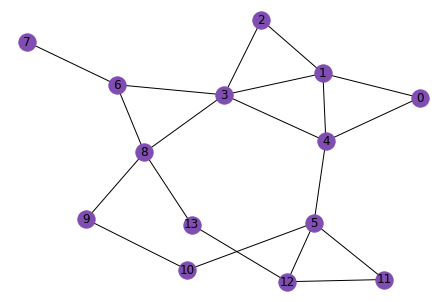

In [3]:
# Since the actual graph is undirected, we convert it for visualization purpose.
nx_G = G.to_networkx().to_undirected()

# Kamada-Kawaii layout usually looks pretty for arbitrary graphs
pos = nx.kamada_kawai_layout(nx_G)
nx.draw(nx_G, pos, with_labels=True, node_color=[[.5, .3, .7]])

## Step 4: Lets load our dataset

In [4]:
NodeFeature = loadmat('NodeFeatures.mat')               # Loading feature matrix from external files
X = NodeFeature['NodeFeatures'].transpose((1, 2, 0))    # Extracting data values from dictionary object
NodeClass = loadmat('NodeLabels.mat')                   # Loading labels from external files 
Y = NodeClass['NodeLabels'].transpose((1,0))            # Extracting data values from dictionary object
print(X.shape,Y.shape)      # print shape of feature and label matrix
n_simulation = X.shape[2]   # Number of simulation in dataset
n_features = X.shape[1]     # total number of features per node
n_node = X.shape[0]         # total number of nodes
n_classes = np.max(Y) + 1   # total number of classes
User_defined = 14           # hidden parameter input to the 2nd convolution layer

(14, 6, 20) (14, 20)


## Step 5: Add node features and labels to the graph

In [5]:
G.ndata['feat'] = torch.LongTensor(X)                        # creating the graph data
G.ndata['label'] = torch.LongTensor(Y)                       # creating the graph data
print(G.ndata['feat'][:,:,2],G.ndata['label'][:,2])          # print out input features of all node at simulation 2

tensor([[  1,   0,   0,   0,   1,   0],
        [  1,  -4,  21,  12,   1,   0],
        [  1, -24,  94,  19,   1,   0],
        [  1, -13,  43,  -3,   1,   0],
        [  1, -10,   7,   1,   1,   0],
        [  1, -15,  11,   7,   1,   0],
        [  1, -16,   0,   0,   1,   0],
        [  1, -16,   0,   0,   1,   0],
        [  1, -18,  27,  15,   1,   0],
        [  1, -18,   8,   5,   1,   0],
        [  1, -18,   3,   1,   1,   0],
        [  1, -16,   6,   1,   1,   0],
        [  1, -16,  12,   5,   1,   0],
        [  1, -18,  13,   4,   1,   0]]) tensor([0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0])


Step 6: Define a Graph Convolutional Network (GCN)
--------------------------------------------------

In [6]:
from dgl.nn.pytorch import GraphConv

# creating a 2/3-layer graph convolutional network model 
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, hidden_size)
        self.conv2 = GraphConv(hidden_size, hidden_size)   # you can add an extra convolution layer amd see the effect
        self.fc1 = nn.Linear(hidden_size,hidden_size)      # First fully connected layer
        self.conv3 = GraphConv(hidden_size, num_classes)   # Output convolution layer
  

    def forward(self, g, inputs):
        h = self.conv1(g, inputs)
        h = torch.relu(h)
        h = self.conv2(g, h)  # comment/uncomment to add/remove additional Conv layer
        h = torch.relu(h)     # comment/uncomment to add/remove additional Conv layer
        h = self.fc1(h)       # comment/uncomment to add/remove a fully connected layer
        h = torch.relu(h)     # comment/uncomment to add/remove a fully connected layer
        h = self.conv3(g, h)
        return h

# The first layer transforms input features of size of "Num_feat" to a hidden size of "User_define".
# The second layer transforms the hidden layer "User_defined" to size of "Num_classes"
net = GCN(n_features,User_defined,n_classes)
print(net)

GCN(
  (conv1): GraphConv(in=6, out=14, normalization=both, activation=None)
  (conv2): GraphConv(in=14, out=14, normalization=both, activation=None)
  (fc1): Linear(in_features=14, out_features=14, bias=True)
  (conv3): GraphConv(in=14, out=2, normalization=both, activation=None)
)


## Step 7: Train-Test split

In [7]:
n_train = 15                    # number of training samples Maximum 20 since number of simulation is 20
n_test = 20 - n_train           # number of test samples
Train_feat = X[:,:,:n_train]    # training set
Test_feat = X[:,:,n_train:]     # test set
Train_labels = Y[:,:n_train]    # training label
Test_labels = Y[:,n_train:]     # testing label
inputs = torch.LongTensor(X)    # Initialize features
labels = torch.LongTensor(Y)    # Initialize labels

## Step 8: Setting up the training loop

In [8]:
# training the model
import torch.optim as optim
learning_rate = 0.001                                        # change learning rate and see the effect on accuracy

optimizer = optim.Adam(net.parameters(), lr= learning_rate)  # We are using ADAM optimizer
all_logits = [] 
n_epoch = 1000                                               # change number of epoch and see the effect on accuracy

for i in range(n_train):
    for epoch in range(n_epoch):
        logits = net(G, inputs[:,:,i])
        # we save the logits for visualization later
        all_logits.append(logits.detach())
        logp = F.log_softmax(logits, 1)
        # Let's compute the model loss
        loss = F.nll_loss(logp, labels[:,i])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    #if epoch > n_epoch-2:            
    print('Epoch %d | Loss: %.4f' % (epoch, loss.item()))  # printing only the last iteration of every epoch

Epoch 999 | Loss: 0.0004
Epoch 999 | Loss: 0.2435
Epoch 999 | Loss: 0.0603
Epoch 999 | Loss: 0.1559
Epoch 999 | Loss: 0.4136
Epoch 999 | Loss: 0.1177
Epoch 999 | Loss: 0.5664
Epoch 999 | Loss: 0.6529
Epoch 999 | Loss: 0.6810
Epoch 999 | Loss: 0.6093
Epoch 999 | Loss: 0.6039
Epoch 999 | Loss: 0.6902
Epoch 999 | Loss: 0.5661
Epoch 999 | Loss: 0.4840
Epoch 999 | Loss: 0.4207


## Step 9: Visulaizing the iterations

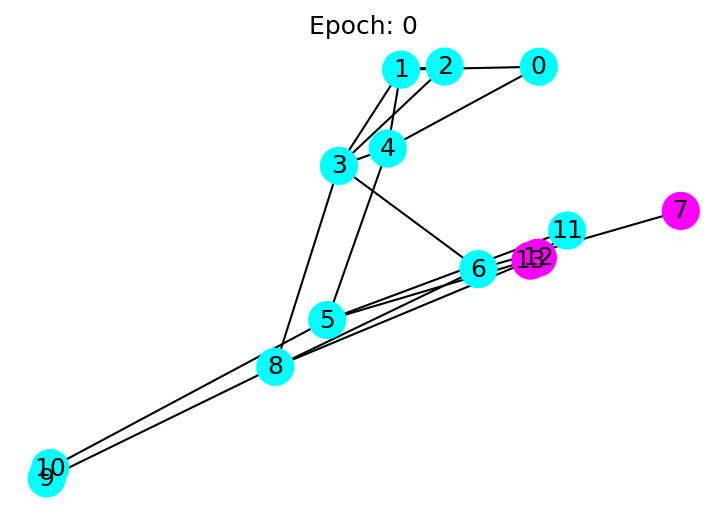

In [9]:
# this function will help us draw the result of each epoch
def draw(i):
    cls1color = '#00FFFF'
    cls2color = '#FF00FF'
    pos = {}
    colors = []
    for v in range(14):
        pos[v] = all_logits[i][v].numpy()
        cls = pos[v].argmax()
        colors.append(cls1color if cls else cls2color)
    ax.cla()
    ax.axis('off')
    ax.set_title('Epoch: %d' % i)
    nx.draw_networkx(nx_G.to_undirected(), pos, node_color=colors,
            with_labels=True, node_size=300, ax=ax)

# lets draw the first epoch
fig = plt.figure(dpi=150)
fig.clf()
ax = fig.subplots()
draw(0)  # draw the prediction of the first epoch
plt.show()

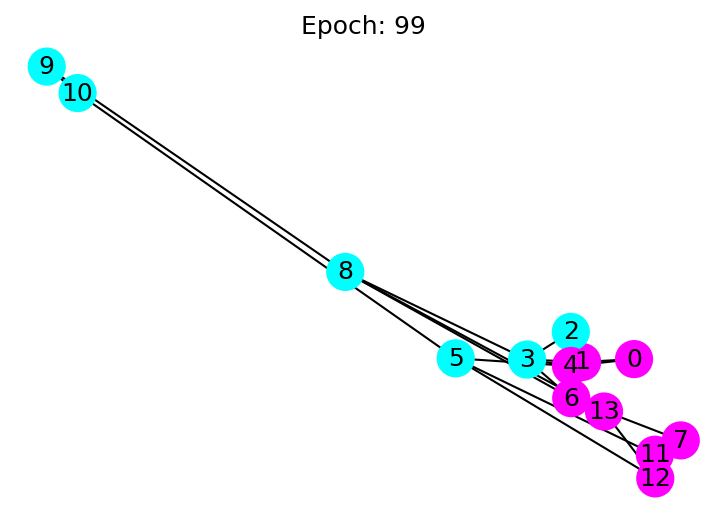

In [10]:
# lets draw the 100th epoch
fig = plt.figure(dpi=150)
fig.clf()
ax = fig.subplots()
draw(99)  # draw the prediction of the 100th epoch
plt.show()

## Step 10: Testing model performance

In [18]:
p = np.random.randint(n_train, n_simulation)                    # randomly selecting a case from test set
logits = net(G, torch.LongTensor(X[:,:,p]))                     # save output from the model
labels = torch.LongTensor(Y[:,p])                               # etract true labels

idx_test  = torch.LongTensor([0,1,2,3,4,5,6,7,8,9,10,11,12,13]) # generating node indexes

lbl2idx = {k:v for v,k in enumerate(sorted(np.unique(labels)))} # given node labels find index
idx2lbl = {v:k for k,v in lbl2idx.items()}                      # given idexes find label

df = pd.DataFrame({'Real': [idx2lbl[e] for e in labels.tolist()],
                   'Pred': [idx2lbl[e] for e in logits.argmax(1).tolist()]})
df['Comp'] = np.where(df['Real']==df['Pred'], np.ones(14),np.zeros(14))
Accuracy = df['Comp'].sum()/n_node*100                          # Clacluating classification accuracy
print('Selected Simulation = %d | Accuracy = (Number of Correctly Predicted Labels/ Total Node) =  %4f ' % (p, Accuracy)) 
print(df)

Selected Simulation = 15 | Accuracy = (Number of Correctly Predicted Labels/ Total Node) =  57.142857 
    Real  Pred  Comp
0      0     0   1.0
1      0     1   0.0
2      1     0   0.0
3      1     1   1.0
4      0     0   1.0
5      1     1   1.0
6      1     0   0.0
7      1     0   0.0
8      0     1   0.0
9      0     0   1.0
10     0     0   1.0
11     0     0   1.0
12     1     0   0.0
13     0     0   1.0


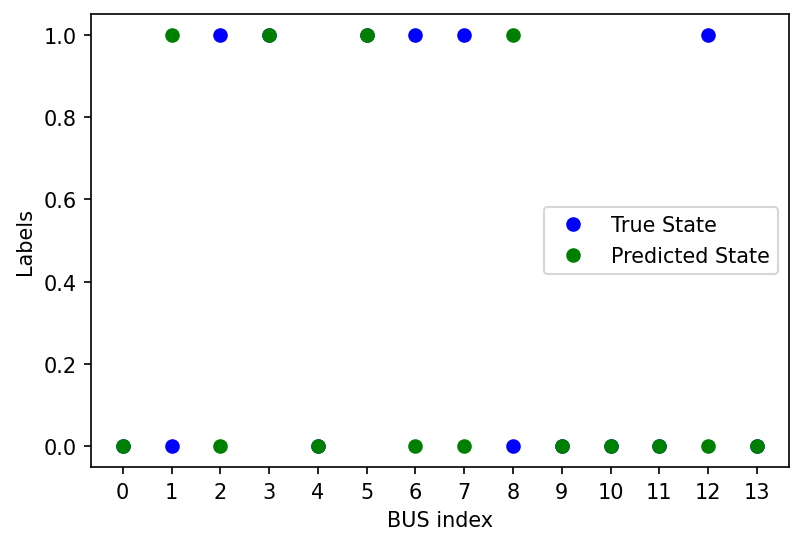

In [19]:
# lets draw the test result
fig = plt.figure(dpi=150)
fig.clf()
#ax = plt.subplots(2)
ax = plt.plot(df['Real'],'bo',label='True State')
ax = plt.plot(df['Pred'],'go',label='Predicted State')
ax = plt.xlabel('BUS index')
ax = plt.ylabel('Labels')
#ax = plt.xticks(np.arange(0, 14, step=1))  # Set BUS indexes.
ax = plt.xticks(idx_test)
ax = plt.legend(loc='best')
plt.show()